In [1]:
import os
import tensorflow as tf
import numpy as np
from scipy import misc
import random
import math
import face_recognition
from skimage import transform
import os.path
import urllib.request
import time
import requests
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

In [2]:
%matplotlib inline

## Set global variables

In [3]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
DENSE_SIZE = 200

### Set up variables and download helpers

In [4]:
START_MONTH = 11
START_DATE = 17
START_SLOT = 6

DESIRED_X = 32
DESIRED_Y = 21
DESIRED_SIZE = 24

NAMES_PER_FILE = 100
TEMP_FILENAME = "temp.png"
monthOn = 0
dayOn = 0
daysInMonth = [31,29,31,30,31,30,31,31,30,31,30,31]
monthNames = ['january','february','march','april','may','june','july','august','september','october','november','december']

def getAvg(face, landmark):
    cum = np.zeros((2))
    for point in face[landmark]:
        cum[0] += point[0]
        cum[1] += point[1]
    return cum/len(face[landmark])

def getNorm(a):
    return (a-np.mean(a))/np.std(a)


## Download all the data

In [ ]:
imageCounter = 0
for monthOn in range(START_MONTH,12):
    thisStartDate = 1
    if monthOn == START_MONTH:
        thisStartDate = START_DATE
    for dayOn in range(thisStartDate,daysInMonth[monthOn]+1):
        response = urllib.request.urlopen("https://www.famousbirthdays.com/"+monthNames[monthOn]+str(dayOn)+".html")
        pageSource = response.read().splitlines()
        lineOn = 0
        while str(pageSource[lineOn]) != "b'<div class=\"container people-list\">'":
            lineOn += 1

        thisStartSlot = 0
        if monthOn == START_MONTH and dayOn == START_DATE:
            thisStartSlot = START_SLOT
        for slotOn in range(0,48):
            while "class=\"face person-item\"" not in str(pageSource[lineOn]):
                lineOn += 1
            iul = str(pageSource[lineOn])
            pnl = str(pageSource[lineOn+4])
            imageURL = iul[iul.index("background: url(")+16:iul.index(") no-repeat center center")]
            personName = ""
            age = ""
            pnl_s = 2
            if pnl[pnl_s] == ' ':
               pnl_s += 1
            if "," in pnl:
                personName = pnl[pnl_s:pnl.index(",")]
                age = pnl[pnl.index(",")+2:-1]
            else:
                personName = pnl[pnl_s:pnl.index("(")-1]
                age = pnl[pnl.index("(")+1:pnl.index(")")]

            if slotOn < thisStartSlot or imageURL == 'https://www.famousbirthdays.com/faces/large-default.jpg' or personName == "Ronan Domingo"  or personName == "Glam And Gore" or personName == "Edith Piaf" or personName == "Lexi Marie":
                print(personName+" SKIPPED!")
            else:
            
                img_data = requests.get(imageURL).content
                with open("temp.png", 'wb') as handler:
                    handler.write(img_data)
                
                image_face_info = face_recognition.load_image_file(TEMP_FILENAME)
                face_landmarks = face_recognition.face_landmarks(image_face_info)

                image_numpy = misc.imread(TEMP_FILENAME)
                colorAmount = 0
                if len(image_numpy.shape) == 3:
                    nR = getNorm(image_numpy[:,:,0])
                    nG = getNorm(image_numpy[:,:,1])
                    nB = getNorm(image_numpy[:,:,2])
                    colorAmount = np.mean(np.square(nR-nG))+np.mean(np.square(nR-nB))+np.mean(np.square(nG-nB))
                if len(face_landmarks) == 1 and colorAmount >= 0.04: # We need there to only be one face in the image, AND we need it to be a colored image.
                    leftEyePosition = getAvg(face_landmarks[0],'left_eye')
                    rightEyePosition = getAvg(face_landmarks[0],'right_eye')
                    nosePosition = getAvg(face_landmarks[0],'nose_tip')
                    mouthPosition = getAvg(face_landmarks[0],'bottom_lip')
            
                    centralPosition = (leftEyePosition+rightEyePosition)/2
            
                    faceWidth = np.linalg.norm(leftEyePosition-rightEyePosition)
                    faceHeight = np.linalg.norm(centralPosition-mouthPosition)
                    if faceWidth >= faceHeight*0.7 and faceWidth <= faceHeight*1.5:

                        faceSize = (faceWidth+faceHeight)/2
            
                        toScaleFactor = faceSize/DESIRED_SIZE
                        toXShift = (centralPosition[0])
                        toYShift = (centralPosition[1])
                        toRotateFactor = np.arctan2(rightEyePosition[1]-leftEyePosition[1],rightEyePosition[0]-leftEyePosition[0])
            
                        rotateT = transform.SimilarityTransform(scale=toScaleFactor,rotation=toRotateFactor,translation=(toXShift,toYShift))
                        moveT = transform.SimilarityTransform(scale=1,rotation=0,translation=(-DESIRED_X,-DESIRED_Y))

                        outputArr = transform.warp(image=image_numpy,inverse_map=(moveT+rotateT))[0:IMAGE_HEIGHT,0:IMAGE_WIDTH]

                        misc.imsave("../data/dataFace"+str(imageCounter)+".png",outputArr)
                        if imageCounter%NAMES_PER_FILE == 0:
                            f = open("../names/name"+str(imageCounter)+".txt","w+")
                        fame = str(slotOn)
                        if monthOn == 1 and dayOn == 29:
                            fame *= 4
                        f.write(personName+","+fame+","+age+"\n")
                        if imageCounter%NAMES_PER_FILE == (NAMES_PER_FILE-1):
                            f.close()
                        print("DAY "+monthNames[monthOn]+" "+str(dayOn)+":  I just used person "+personName+" to create image number "+str(imageCounter))
                        imageCounter += 1
                time.sleep(0.5)
            lineOn += 1


### Store images count

In [6]:
images_count = len(os.listdir('../data/'))

### Setup helper functions

In [7]:
def CreateAutoEncoder():
    input_img = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # adapt this if using `channels_first` image data format

    x = Conv2D(40, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(80, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(DENSE_SIZE, activation='relu')(x)

    y = Dense(3200, activation='relu')(encoded)
    y = Reshape([4,4,200])(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(150, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(80, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(40, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(15, (3, 3), activation='relu', padding='same')(y)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(y)

    autoencoder = Model(input_img, decoded)
    #optimizer = tf.keras.optimizers.Adam(lr=0.005)
    autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')
    return autoencoder

In [8]:
def WriteOutputFileResult(epoch):
    if epoch%10!=0:
        return
    
    imageIndex = np.random.randint(images_count)
    output = autoencoder.predict(batch_data[imageIndex].reshape(1,64,64,3))
    exampleImage = np.empty([IMAGE_HEIGHT*2,IMAGE_WIDTH,3])
    exampleImage[0:IMAGE_HEIGHT,0:IMAGE_WIDTH,0:3] = batch_data[imageIndex,0:IMAGE_HEIGHT,0:IMAGE_WIDTH,0:3]
    exampleImage[IMAGE_HEIGHT:IMAGE_HEIGHT*2,0:IMAGE_WIDTH,0:3] = output[0,0:IMAGE_HEIGHT,0:IMAGE_WIDTH,0:3]
    exampleImage = np.clip(exampleImage, 0, 1)
    misc.imsave('../modelExamples/encoder'+str(epoch)+'.png',exampleImage)

    save_path='../models/keras.h5'
    autoencoder.save(save_path)
    print("MODEL SAVED: "+str(save_path))

## Train autoencoder

In [ ]:
from tensorflow.keras.models import load_model
modelPath = '../models/keras.h5'
if os.path.isfile(modelPath):
    print('Loading existing model')
    autoencoder = load_model('../models/keras.h5', custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform})
else:
    print('Creating new model')
    autoencoder = CreateAutoEncoder()
batch_data = np.empty([images_count,IMAGE_HEIGHT,IMAGE_WIDTH,3])
for example in range(images_count):
    imageIndex = example# +  int(math.floor(random.randrange(images_count)))
    imagio = misc.imread('../data/dataFace'+str(imageIndex)+'.png')
    batch_data[example] = imagio[:,:,0:3]/255.0
autoencoder.fit(batch_data, batch_data,
    epochs=10000,
    batch_size=100,
    shuffle=True,
    #validation_data=(batch_data, batch_data),
    callbacks=[
        #tf.keras.callbacks.ModelCheckpoint('../models/keras.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
        tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: WriteOutputFileResult(epoch))
    ])



## Tear apart encoder and decoder

In [10]:
[layer.name for layer in autoencoder.layers]

['input_3',
 'conv2d_18',
 'max_pooling2d_8',
 'conv2d_19',
 'max_pooling2d_9',
 'conv2d_20',
 'max_pooling2d_10',
 'conv2d_21',
 'max_pooling2d_11',
 'flatten_2',
 'dense_4',
 'dense_5',
 'reshape_2',
 'up_sampling2d_8',
 'conv2d_22',
 'up_sampling2d_9',
 'conv2d_23',
 'up_sampling2d_10',
 'conv2d_24',
 'up_sampling2d_11',
 'conv2d_25',
 'conv2d_26']

In [11]:
encoder = Sequential()
for i in range(0,11):
    encoder.add(autoencoder.layers[i])
encoder.build()

decoder = Sequential()
for i in range(11,len(autoencoder.layers)):
    decoder.add(autoencoder.layers[i])
    
decoder.build(input_shape=(None, 200))

In [12]:
def getEncodedImage(index):
    image = misc.imread('../data/dataFace'+str(index)+'.png')
    image = image[:,:,0:3]/255.0
    return image

### Preview random image to be encoded

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


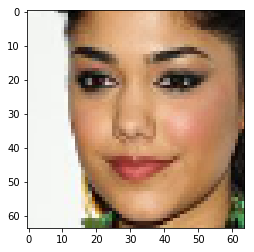

In [13]:
randIndex = np.random.randint(0, images_count)
image = getEncodedImage(randIndex)
plt.imshow(image)

In [14]:
encoded = encoder.predict(image.reshape([-1, image.shape[0], image.shape[1], image.shape[2]]))
print('Encoded image:\n' ,encoded[0])

Encoded image:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.6740656  0.
 0.         1.2446964  0.         0.         4.6464124  2.7161005
 4.744044   0.         0.         0.         1.0253751  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.516001   0.         0.         0.         0.         0.
 0.         0.         0.         0.         2.0416033  0.
 1.2738434  0.         0.         0.         4.646125   0.
 2.3047757  0.         0.         0.6224123  4.424849   0.
 0.         1.1240004  0.         0.         0.         1.548488
 0.         0.4614426  0.         0.         0.         0.
 0.         1.1851753  1.2601664  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.5733514  0.         0.         0.         0.         0.18939778
 1.6195832  4.0283566  0.         0.         0.         1.4311539
 0.         

In [15]:
decoded = decoder.predict(encoded)

### Recreate image from encoded state

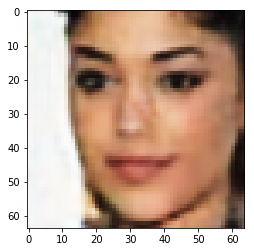

In [16]:
plt.imshow(decoded[0])

## Create dataframe to inspect all encoded images together

In [17]:
import pandas as pd

In [18]:
all_rows = []
for i in range(images_count):
    image = getEncodedImage(i)
    encoded_internal = encoder.predict(image.reshape([-1, image.shape[0], image.shape[1], image.shape[2]]))[0]
    all_rows.append(encoded_internal)
df = pd.DataFrame(all_rows)
df.describe()
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
count,527.0,527.000000,527.0,527.000000,527.0,527.0,527.0,527.000000,527.0,527.0,...,527.000000,527.0,527.0,527.000000,527.000000,527.0,527.000000,527.0,527.000000,527.000000
mean,0.0,0.383350,0.0,0.497579,0.0,0.0,0.0,1.563971,0.0,0.0,...,0.588612,0.0,0.0,0.292458,0.928342,0.0,0.658084,0.0,0.906207,0.520338
std,0.0,1.190903,0.0,1.101257,0.0,0.0,0.0,1.455407,0.0,0.0,...,1.390174,0.0,0.0,1.263822,1.070300,0.0,1.130944,0.0,1.259891,1.474352
min,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.294710,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
50%,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.333912,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.655429,0.0,0.000000,0.0,0.324040,0.000000
75%,0.0,0.000000,0.0,0.328242,0.0,0.0,0.0,2.321734,0.0,0.0,...,0.510635,0.0,0.0,0.000000,1.580515,0.0,0.958642,0.0,1.432640,0.000000
max,0.0,7.928043,0.0,8.070414,0.0,0.0,0.0,8.701365,0.0,0.0,...,12.323253,0.0,0.0,14.501927,5.239333,0.0,6.052303,0.0,6.644118,9.616698


## Save mean from encodings to file

In [19]:

mean = df.mean().values.tolist()

text_file = open("../models/mean.json", "w")
text_file.write(json.dumps(mean))
text_file.close()

## Filter out columns all containing zeros

In [20]:
m2 = df.loc[:, (df != 0).any(axis=0)]

In [21]:
m2.describe()

,1,3,7,10,13,16,17,18,19,21,...,179,180,183,184,190,193,194,196,198,199
count,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,...,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,0.383350,0.497579,1.563971,1.032203,0.645219,1.415085,0.818090,0.795896,1.025534,0.855816,...,0.830482,0.720698,0.921920,1.092613,0.588612,0.292458,0.928342,0.658084,0.906207,0.520338
std,1.190903,1.101257,1.455407,1.125508,1.383625,1.554425,1.545218,1.385235,1.114971,1.103555,...,1.060839,1.136248,1.201186,1.640923,1.390174,1.263822,1.070300,1.130944,1.259891,1.474352
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.294710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.333912,0.756519,0.000000,1.057168,0.000000,0.000000,0.758654,0.457324,...,0.382845,0.000000,0.473265,0.104616,0.000000,0.000000,0.655429,0.000000,0.324040,0.000000
75%,0.000000,0.328242,2.321734,1.556919,0.611775,2.378852,1.168464,1.147271,1.744949,1.374141,...,1.381343,1.199598,1.443289,1.651781,0.510635,0.000000,1.580515,0.958642,1.432640,0.000000
max,7.928043,8.070414,8.701365,5.879054,10.312868,6.995349,9.534487,8.131895,6.139172,6.481678,...,5.561953,6.141798,6.244396,9.122747,12.323253,14.501927,5.239333,6.052303,6.644118,9.616698


In [22]:
pca_columns = len(m2.columns)

### This number shows how many principal components are needed
#### We can take only non-zero columns from our encodings table
This will allow to use fewer components

In [23]:
pca_columns

107

## Manual PCA

In [24]:
np_all_rows = np.asarray(all_rows)

pca = PCA(n_components=pca_columns)
pca.fit(np_all_rows)
values = np.sqrt(pca.explained_variance_)
vectors = pca.components_

json_vectors = json.dumps(vectors.tolist())
json_values = json.dumps(values.tolist())

all_rows_pca = pca.transform(np_all_rows)

sliders_min = all_rows_pca.min(axis=0)
sliders_max = all_rows_pca.max(axis=0)
json_sliders_min = json.dumps(sliders_min.tolist())
json_sliders_max = json.dumps(sliders_max.tolist())

text_file = open("../models/eigenVectors.json", "w")
text_file.write(json_vectors)
text_file.close()

text_file = open("../models/eigenValues.json", "w")
text_file.write(json_values)
text_file.close()

text_file = open("../models/slidersMin.json", "w")
text_file.write(json_sliders_min)
text_file.close()

text_file = open("../models/slidersMax.json", "w")
text_file.write(json_sliders_max)
text_file.close()

## Load data as it will be loaded by tensorflowJS in the browser

In [25]:
with open('../models/eigenVectors.json') as f:
    eigenVectors = np.asarray(json.load(f))
with open('../models/eigenValues.json') as f:
    eigenValues = np.asarray(json.load(f))
with open('../models/mean.json') as f:
    meanData = np.asarray(json.load(f))

In [26]:
eigenvectorInverses = np.linalg.pinv(eigenVectors)

In [27]:
traits = encoded[0] - meanData
image_pca = np.matmul(traits, eigenvectorInverses) / eigenValues

In [28]:
image_pca

array([-1.21494064e+00, -4.95205738e-01,  1.58773161e+00,  1.03317212e+00,
        1.64704590e-02,  8.42720705e-02,  6.85427567e-02, -2.79387655e+00,
        1.87637418e+00,  7.37616443e-02,  2.54778020e-01, -1.77222121e-01,
        1.13375160e+00, -1.30607305e-01, -5.21181651e-01,  1.04267917e+00,
       -5.30473454e-01, -9.19137177e-01, -6.33939878e-01,  1.90321028e+00,
        1.06104141e+00, -7.84540597e-01,  6.10745502e-01,  7.75544652e-01,
       -3.78812174e-01, -8.48271968e-01, -9.15274639e-01, -5.84614425e-02,
        4.95471393e-01, -8.18511609e-01,  1.17733230e-01,  7.96533237e-01,
        3.81170546e-01, -7.34867326e-01, -1.80153036e-01,  2.69993923e-01,
       -4.40699800e-01,  4.58954842e-01,  1.20221894e+00,  1.05707949e+00,
       -9.26709735e-01, -2.62151517e-01,  4.12873764e-01,  9.51895180e-01,
       -1.82035008e-01,  2.05909696e-01, -3.62205891e-02,  1.64909150e-01,
        3.50870550e-02, -6.51322007e-01, -1.10071462e+00,  1.10239015e-01,
        1.00940874e+00, -

In [29]:
recovered_from_pca = meanData.copy()
for i in range(pca_columns):
    recovered_from_pca += image_pca[i] * eigenValues[i] * eigenVectors[i]

In [30]:
recovered_from_pca

array([-8.30572673e-07, -8.26042793e-15,  7.28689154e-07, -1.38158148e-13,
       -4.69476584e-07, -1.24504785e-07, -4.88584873e-07,  1.88553600e-13,
        1.75781359e-07,  8.27562621e-07,  1.67406559e+00,  2.58648698e-07,
       -1.61953981e-07,  1.24469638e+00, -1.84599036e-07,  3.55158112e-07,
        4.64641237e+00,  2.71610045e+00,  4.74404383e+00,  1.98366497e-13,
       -1.74709958e-07, -7.35730921e-14,  1.02537513e+00,  5.83238056e-07,
       -1.10047388e-13,  3.03989825e-07, -1.23132841e-13, -3.87376862e-07,
        1.58832694e-07, -2.72547013e-07,  3.58801530e-14,  1.76143822e-14,
       -4.30501988e-14, -2.59269578e-07, -2.51543659e-07,  9.44383460e-14,
        5.16000986e-01,  2.46116744e-07,  3.67596578e-14,  6.68791436e-07,
       -3.52233793e-08,  4.35242120e-14, -3.67191394e-08,  1.43867990e-13,
        2.98658325e-07,  3.94759415e-08,  2.04160333e+00, -1.50137861e-07,
        1.27384341e+00, -1.00947029e-13, -1.36277723e-07, -1.51687690e-13,
        4.64612484e+00, -

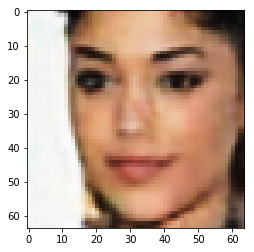

In [31]:
decoded = decoder.predict(recovered_from_pca.reshape(1,DENSE_SIZE))
plt.imshow(decoded[0])

### Save all images as encodings in json file

In [32]:
json_all_rows_pca = json.dumps(all_rows_pca.tolist())

text_file = open("../models/facesPca.json", "w")
text_file.write(json_all_rows_pca)
text_file.close()